<a href="https://colab.research.google.com/github/ronalds82/Datu-kopas-tulkosana/blob/main/Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autors: *Ronalds Turnis, rt20018*
===========================


# Globālie mainīgie

In [1]:
INSTALL = False # True, ja videi ir nepieciešamas papildus instalācijas
TRAIN = True  # True, ja modelim ir nepieciešama satura regulēšana
FINE_TUNED = False # True, ja testējam pašu saglabātu modeli

weights_dir = './weights' # Tiek glabāti modeļa svari
logs_dir = './logs' # Tiek glabāta notikumu informācija
tmp_dir = './tmp_trainer' # Glabājās pagaidu informācija

# Jānorāda, ja vēlamies veikt pašu saglabāta modeļa novērtēšanu
model_link = 'https://www.dropbox.com/scl/fi/cguiqykr0jlp1yj6mi7rm/modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu&dl=0'
model_weight_file = 'modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu'

model_name = 'openai-community/gpt2' # Modeļa izvēle

data_files = {'train': 'instruct-train-LV.json', 'validation': 'instruct-validate.json'}

# Moduļu importēšana

In [2]:
# Ja ir nepieciešamas papildus instalācijas
if INSTALL:
    !pip install datasets
    !pip install ipyfilechooser
    !pip install transformers[torch] -U
    !pip install accelerate -U

# Importējam nepieciešamos moduļus
import torch
import matplotlib.pyplot as plt
import shutil
import os
import json
from transformers import Trainer, TrainingArguments, IntervalStrategy, DataCollatorWithPadding, AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, AutoModelForCausalLM, trainer_utils, BartForConditionalGeneration, BartTokenizer
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

# Modeļa un tokenizera inicializācija

In [3]:
print("Ielādējam modeli un tokenizeru...")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Iestatām padding tokenu, ja tā nav
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelis un tokenizeris inicializēts!")
print("Izmantotā ierīce:", device)

Ielādējam modeli un tokenizeru...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Modelis un tokenizeris inicializēts!
Izmantotā ierīce: cuda


# Datņu ielādēšana

In [4]:
def load_data(file_name):
    try:
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Fails {file_name} nav atrasts!")
        return []

train_data = load_data(data_files['train'])
val_data = load_data(data_files['validation'])

# Iepriekšējo datu dzēšana

In [5]:
# Pārbaudām vai eksistē ģenerētās direktorijas un dzēšam tās pirms modeļa trenēšanas, lai nekonfliktētu ar vecajiem datiem
def delete_directory(dir_path):
    try:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Direktorija dzēsta: {dir_path}")
        else:
            print(f"Direktorija neeksistē: {dir_path}")
    except Exception as e:
        print(f"Kļūda dzēšot direktoriju: {e}")

delete_directory(weights_dir)
delete_directory(logs_dir)
delete_directory(tmp_dir)

# Izdzēšam GPU kešatmiņu
torch.cuda.empty_cache()

Direktorija dzēsta: ./weights
Direktorija neeksistē: ./logs
Direktorija neeksistē: ./tmp_trainer


# Datu inicializācija

In [6]:
class InstructDataset(Dataset):
    def __init__(self, data_file, max_length=384):
        with open(data_file, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        instruction = item.get('instruction', '')
        input_text = item.get('input', '')
        output_text = item.get('output', '')
        forbidden_words = item.get('forbidden_words', [])
        is_correct = item.get('is_correct', False)

        # Tokenizējam instrukciju un ievadu vienlaikus
        inputs = self.tokenizer(
            instruction + ' ' + input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenizējam izvades tekstu
        labels = self.tokenizer(
            output_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        labels = labels['input_ids'].squeeze()

        # Padding tokenus aizvietojam ar -100
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "forbidden_words": forbidden_words,
            "is_correct": torch.tensor(is_correct, dtype=torch.float)
        }

# Definējam data collatoru
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Sagatavojam datu kopas
train_dataset = InstructDataset(data_files['train'])
val_dataset = InstructDataset(data_files['validation'])

print(f"Apmācības datu kopas izmērs: {len(train_dataset)}")
print(f"Validācijas datu kopas izmērs: {len(val_dataset)}")

Apmācības datu kopas izmērs: 94
Validācijas datu kopas izmērs: 34


# Metriku aprēķināšanas funkcijas

In [7]:
# Metriku vēsture
metrics_history = []

def simple_stem(word):
    # Galotņu saraksts
    suffixes = [
        's', 'š', 'a', 'am', 'u', 'ā', 'i', 'iem', 'us', 'os', 'im', 'ī',
        'as', 'ai', 'iu', 'es', 'ei', 'ēm', 'ij', 'um', 'ū', 'ai', 'iu',
        'ei', 'ēm', 'īm', 'ēs', 'ās', 'ies', 'ūm', 'ūs'
    ]

    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

# Normalizē tekstu, izmantojot stemmer funkciju
def normalize_text(text):
    words = text.lower().split()
    normalized_words = [simple_stem(word) for word in words]
    return " ".join(normalized_words)

# Skaita aizliegtos vārdus tekstā
def count_forbidden_words(text, forbidden_words):
    normalized_text = normalize_text(text)
    normalized_forbidden_words = [normalize_text(word) for word in forbidden_words]
    return any(word in normalized_text.split() for word in normalized_forbidden_words)

# Aprēķina metriku
def compute_metrics(pred: trainer_utils.EvalPrediction) -> dict:
    predictions = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    label_ids = pred.label_ids

    # Dekodē prognozes un anotācijas
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    decoded_labels = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    # Iegūst aizliegto vārdu sarakstu un pareizības informāciju no validācijas kopas
    forbidden_words_list = [data['forbidden_words'] for data in val_dataset.data]
    is_correct_list = [data['is_correct'] for data in val_dataset.data]

    # Aprēķina aizliegto vārdu metrikas
    forbidden_word_counts = [count_forbidden_words(text, fw) for text, fw in zip(decoded_predictions, forbidden_words_list)]
    forbidden_word_labels = [1 if fw else 0 for fw in forbidden_word_counts]

    # Pārveido aizliegto vārdu klātbūtni par bināriem rādītājiem precizitātes un F1 rādītāja aprēķināšanai
    predicted_labels = [1 if count else 0 for count in forbidden_word_counts]

    # Aprēķina precizitāti un F1 rādītāju aizliegtajiem vārdiem
    forbidden_word_percentage = sum(predicted_labels) / len(predicted_labels) * 100

    # Pievieno precizitāti, F1 rādītāju un aizliegto vārdu metrikas rezultātiem
    metric_results = {
        "forbidden_word_percentage": forbidden_word_percentage
    }

    # Saglabā metrikas vēsturi
    metrics_history.append(metric_results)

    return metric_results

# Funkcija, lai izvairītos no atmiņas problēmām
def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

# Modeļa trenēšana

In [8]:
def custom_loss(logits, labels, outputs, forbidden_words_list):
    ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), reduction='mean')

    # Sodīšana par aizliegtajiem vārdiem
    forbidden_penalty = 0
    for output, forbidden_words in zip(outputs, forbidden_words_list):
        if count_forbidden_words(output, forbidden_words):
            forbidden_penalty += 1

    # Apvienojam zaudējumus
    total_loss = ce_loss + (forbidden_penalty * 0.1)
    return total_loss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Dekodējam prognozi aizliegto vārdu pārbaudei
        decoded_outputs = tokenizer.batch_decode(logits.argmax(dim=-1), skip_special_tokens=True)
        forbidden_words_list = inputs.get("forbidden_words")
        loss = custom_loss(logits, labels, decoded_outputs, forbidden_words_list)
        return (loss, outputs) if return_outputs else loss

def train_model(model, train_dataset, val_dataset, output_dir):
    # Konfigurējam apmācības parametrus
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        eval_strategy=IntervalStrategy.STEPS,
        eval_steps=10,
        warmup_steps=10,
        weight_decay=0.01,
        learning_rate=1e-4,
        logging_dir=logs_dir,
        logging_steps=10,
        save_strategy=IntervalStrategy.EPOCH,
        report_to="none",
        fp16=True
    )

    # Inicializējam traineri
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        data_collator=data_collator
    )

    # Trenējam modeli
    trainer.train()
    return trainer

if TRAIN:
    trainer = train_model(model, train_dataset, val_dataset, weights_dir)
else:
    # Inicializējam traineri validācijas dēļ
    trainer = Trainer(
        model=model,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        data_collator=data_collator
    )

Step,Training Loss,Validation Loss,Forbidden Word Percentage
10,8.399700,7.343064,0.000000
20,6.720500,6.389512,0.000000
30,6.096000,6.143975,0.000000
40,5.829100,6.048105,0.000000
50,5.766100,6.056396,0.000000
60,5.464500,6.050166,0.000000
70,5.484800,5.979290,0.000000
80,5.364700,6.005744,0.000000
90,5.354600,6.034008,0.000000
100,5.306300,6.033227,0.000000


# Apmācīta modeļa analīze

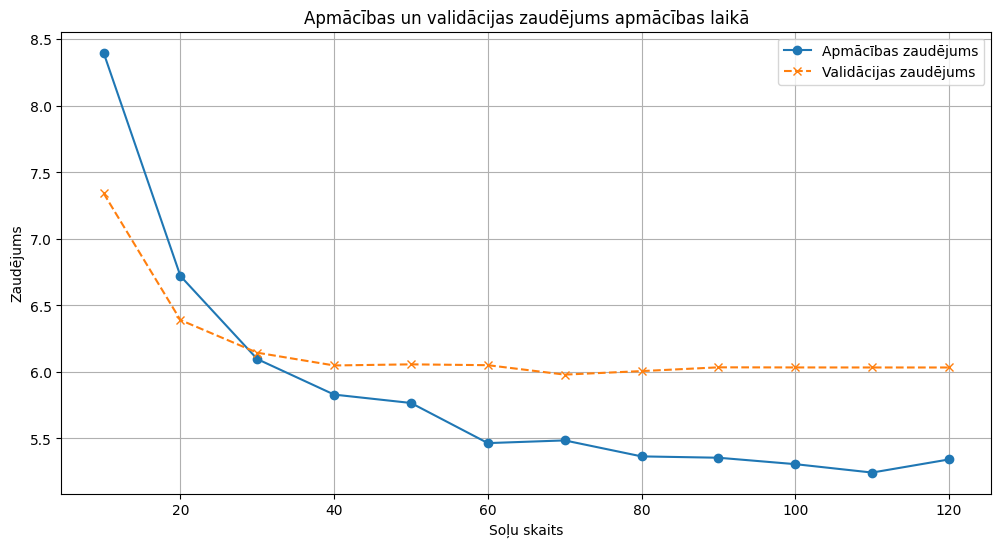

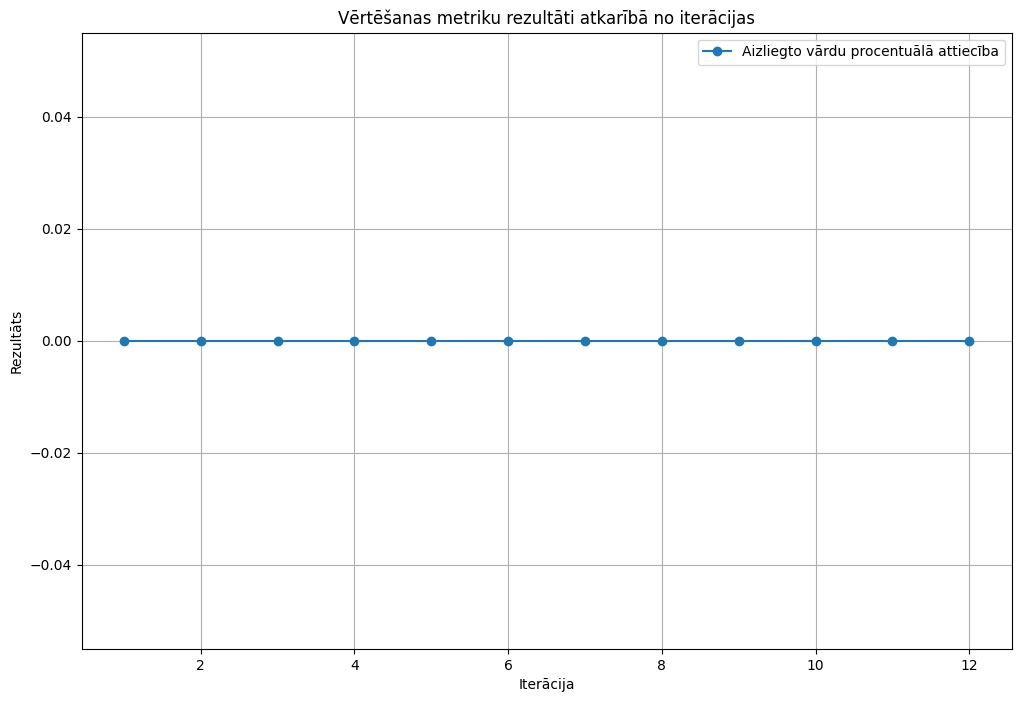

In [9]:
def plot_results(training_history):
    # Definējam sarakstus uzskaitei
    steps = []
    training_losses = []
    validation_losses = []

    # Ejam cauri katram ierakstam vēsturē
    for entry in training_history:
        if 'loss' in entry:  # Apmācības zaudējums
            steps.append(entry.get('step', len(steps) + 1))
            training_losses.append(entry['loss'])

        if 'eval_loss' in entry:  # Validācijas zaudējums
            validation_losses.append(entry['eval_loss'])

    # Izveidojam grafiku
    plt.figure(figsize=(12, 6))

    if training_losses:
        plt.plot(steps[:len(training_losses)], training_losses, label='Apmācības zaudējums', marker='o')

    if validation_losses:
        validation_steps = steps[:len(validation_losses)]
        plt.plot(validation_steps, validation_losses, label='Validācijas zaudējums', marker='x', linestyle='--')

    plt.xlabel('Soļu skaits')
    plt.ylabel('Zaudējums')
    plt.title('Apmācības un validācijas zaudējums apmācības laikā')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics_history(metrics_history):
    epochs = list(range(1, len(metrics_history)+1))
    plt.figure(figsize=(12, 8))

    # Sagatavojam datus parādīšanai grafikā
    forbidden_word_percentages = [x['forbidden_word_percentage'] for x in metrics_history]

    # Plot accuracy and F1 scores
    plt.plot(epochs, forbidden_word_percentages, label='Aizliegto vārdu procentuālā attiecība', marker='o')

    plt.xlabel('Iterācija')
    plt.ylabel('Rezultāts')
    plt.title('Vērtēšanas metriku rezultāti atkarībā no iterācijas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Izpildām tikai, ja ir notikusi modeļa pielāgošana, citādi tas tiks darīts "Saglabātā modeļa izmantošana" sadaļā
if TRAIN:
    plot_results(trainer.state.log_history)
    print()
    plot_metrics_history(metrics_history)

# Apmācīta modeļa saglabāšana

In [10]:
if TRAIN:
    model_weights = 'modelis.pth'
    torch.save(model.state_dict(), model_weights)

# Neapmācīta modeļa analīze



In [11]:
if FINE_TUNED:
    !wget model_link

    # Ielādējam saglabātos svarus
    model.load_state_dict(torch.load(model_weight_file))

    # Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    trainer.evaluate(val_dataset)
    plot_metrics_history(metrics_history)

if TRAIN == False:
    # Ieslēdzam validācijas režīmu
    trainer.evaluate(val_dataset)
    plot_metrics_history(metrics_history)